In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(226755, 828)
(226755, 1)
validation
(42717, 828)
(42717, 1)
test
(21245, 828)
(21245, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/23 [>.............................] - ETA: 33s - loss: 0.1557 - STD: 1.8961e-04 - MAE: 0.3792

 4/23 [====>.........................] - ETA: 0s - loss: 0.0580 - STD: 3.0980e-04 - MAE: 0.1834 

 5/23 [=====>........................] - ETA: 0s - loss: 0.0535 - STD: 2.7695e-04 - MAE: 0.1758

 6/23 [======>.......................] - ETA: 0s - loss: 0.0514 - STD: 2.4640e-04 - MAE: 0.1731

 7/23 [========>.....................] - ETA: 2s - loss: 0.0502 - STD: 2.2063e-04 - MAE: 0.1712

10/23 [============>.................] - ETA: 1s - loss: 0.0467 - STD: 1.7235e-04 - MAE: 0.1664

12/23 [==============>...............] - ETA: 1s - loss: 0.0441 - STD: 1.5820e-04 - MAE: 0.1600

13/23 [===============>..............] - ETA: 1s - loss: 0.0426 - STD: 1.5444e-04 - MAE: 0.1556

14/23 [=================>............] - ETA: 0s - loss: 0.0409 - STD: 1.5204e-04 - MAE: 0.1503

15/23 [==================>...........] - ETA: 0s - loss: 0.0393 - STD: 1.5048e-04 - MAE: 0.1450

16/23 [===================>..........] - ETA: 0s - loss: 0.0378 - STD: 1.4948e-04 - MAE: 0.1408

17/23 [=====================>........] - ETA: 0s - loss: 0.0365 - STD: 1.4852e-04 - MAE: 0.1379

18/23 [======================>.......] - ETA: 0s - loss: 0.0354 - STD: 1.4749e-04 - MAE: 0.1361

19/23 [=======================>......] - ETA: 0s - loss: 0.0345 - STD: 1.4629e-04 - MAE: 0.1353

20/23 [=========================>....] - ETA: 0s - loss: 0.0338 - STD: 1.4489e-04 - MAE: 0.1349

21/23 [==========================>...] - ETA: 0s - loss: 0.0332 - STD: 1.4342e-04 - MAE: 0.1346

22/23 [===========================>..] - ETA: 0s - loss: 0.0325 - STD: 1.4180e-04 - MAE: 0.1341

23/23 [==============================] - ETA: 0s - loss: 0.0319 - STD: 1.4015e-04 - MAE: 0.1333

23/23 [==============================] - 4s 117ms/step - loss: 0.0319 - STD: 1.4015e-04 - MAE: 0.1333 - val_loss: 0.0181 - val_STD: 8.2148e-05 - val_MAE: 0.1150


Epoch 2/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0163 - STD: 9.9709e-05 - MAE: 0.1030

 2/23 [=>............................] - ETA: 1s - loss: 0.0160 - STD: 9.7705e-05 - MAE: 0.0984

 3/23 [==>...........................] - ETA: 1s - loss: 0.0155 - STD: 9.6128e-05 - MAE: 0.0933

 4/23 [====>.........................] - ETA: 1s - loss: 0.0155 - STD: 9.4545e-05 - MAE: 0.0895

 5/23 [=====>........................] - ETA: 1s - loss: 0.0157 - STD: 9.3200e-05 - MAE: 0.0865

 6/23 [======>.......................] - ETA: 1s - loss: 0.0159 - STD: 9.1969e-05 - MAE: 0.0841

 7/23 [========>.....................] - ETA: 0s - loss: 0.0159 - STD: 9.0971e-05 - MAE: 0.0820

 8/23 [=========>....................] - ETA: 0s - loss: 0.0161 - STD: 9.0292e-05 - MAE: 0.0809

 9/23 [==========>...................] - ETA: 0s - loss: 0.0162 - STD: 8.9776e-05 - MAE: 0.0799

10/23 [============>.................] - ETA: 0s - loss: 0.0162 - STD: 8.9586e-05 - MAE: 0.0791

11/23 [=============>................] - ETA: 0s - loss: 0.0163 - STD: 8.9677e-05 - MAE: 0.0784

12/23 [==============>...............] - ETA: 0s - loss: 0.0162 - STD: 9.0023e-05 - MAE: 0.0778

13/23 [===============>..............] - ETA: 0s - loss: 0.0162 - STD: 9.0592e-05 - MAE: 0.0773

14/23 [=================>............] - ETA: 0s - loss: 0.0162 - STD: 9.1425e-05 - MAE: 0.0772

15/23 [==================>...........] - ETA: 0s - loss: 0.0160 - STD: 9.2357e-05 - MAE: 0.0772

16/23 [===================>..........] - ETA: 0s - loss: 0.0160 - STD: 9.3461e-05 - MAE: 0.0775

17/23 [=====================>........] - ETA: 0s - loss: 0.0159 - STD: 9.4712e-05 - MAE: 0.0780

18/23 [======================>.......] - ETA: 0s - loss: 0.0159 - STD: 9.6046e-05 - MAE: 0.0786

19/23 [=======================>......] - ETA: 0s - loss: 0.0158 - STD: 9.7389e-05 - MAE: 0.0792

20/23 [=========================>....] - ETA: 0s - loss: 0.0158 - STD: 9.8749e-05 - MAE: 0.0799

21/23 [==========================>...] - ETA: 0s - loss: 0.0158 - STD: 1.0018e-04 - MAE: 0.0806

22/23 [===========================>..] - ETA: 0s - loss: 0.0158 - STD: 1.0151e-04 - MAE: 0.0811

23/23 [==============================] - ETA: 0s - loss: 0.0158 - STD: 1.0281e-04 - MAE: 0.0815

23/23 [==============================] - 2s 67ms/step - loss: 0.0158 - STD: 1.0281e-04 - MAE: 0.0815 - val_loss: 0.0163 - val_STD: 1.0697e-04 - val_MAE: 0.0976


Epoch 3/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0150 - STD: 1.3478e-04 - MAE: 0.0869

 2/23 [=>............................] - ETA: 1s - loss: 0.0151 - STD: 1.3503e-04 - MAE: 0.0856

 3/23 [==>...........................] - ETA: 1s - loss: 0.0151 - STD: 1.3600e-04 - MAE: 0.0840

 4/23 [====>.........................] - ETA: 1s - loss: 0.0153 - STD: 1.3712e-04 - MAE: 0.0831

 5/23 [=====>........................] - ETA: 1s - loss: 0.0152 - STD: 1.3799e-04 - MAE: 0.0819

 6/23 [======>.......................] - ETA: 0s - loss: 0.0153 - STD: 1.3915e-04 - MAE: 0.0809

 7/23 [========>.....................] - ETA: 0s - loss: 0.0153 - STD: 1.4023e-04 - MAE: 0.0801

 8/23 [=========>....................] - ETA: 0s - loss: 0.0153 - STD: 1.4153e-04 - MAE: 0.0795

 9/23 [==========>...................] - ETA: 0s - loss: 0.0153 - STD: 1.4310e-04 - MAE: 0.0790

10/23 [============>.................] - ETA: 0s - loss: 0.0153 - STD: 1.4476e-04 - MAE: 0.0787

11/23 [=============>................] - ETA: 0s - loss: 0.0152 - STD: 1.4644e-04 - MAE: 0.0782

12/23 [==============>...............] - ETA: 0s - loss: 0.0152 - STD: 1.4859e-04 - MAE: 0.0781

13/23 [===============>..............] - ETA: 0s - loss: 0.0152 - STD: 1.5090e-04 - MAE: 0.0782

14/23 [=================>............] - ETA: 0s - loss: 0.0152 - STD: 1.5325e-04 - MAE: 0.0783

15/23 [==================>...........] - ETA: 0s - loss: 0.0151 - STD: 1.5551e-04 - MAE: 0.0785

17/23 [=====================>........] - ETA: 0s - loss: 0.0151 - STD: 1.6062e-04 - MAE: 0.0790

18/23 [======================>.......] - ETA: 0s - loss: 0.0152 - STD: 1.6337e-04 - MAE: 0.0793

19/23 [=======================>......] - ETA: 0s - loss: 0.0151 - STD: 1.6605e-04 - MAE: 0.0796

20/23 [=========================>....] - ETA: 0s - loss: 0.0151 - STD: 1.6875e-04 - MAE: 0.0798

21/23 [==========================>...] - ETA: 0s - loss: 0.0151 - STD: 1.7150e-04 - MAE: 0.0799

22/23 [===========================>..] - ETA: 0s - loss: 0.0151 - STD: 1.7429e-04 - MAE: 0.0800

23/23 [==============================] - ETA: 0s - loss: 0.0152 - STD: 1.7722e-04 - MAE: 0.0802

23/23 [==============================] - 2s 66ms/step - loss: 0.0152 - STD: 1.7722e-04 - MAE: 0.0802 - val_loss: 0.0161 - val_STD: 1.9764e-04 - val_MAE: 0.0919


Epoch 4/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0144 - STD: 2.4447e-04 - MAE: 0.0792

 2/23 [=>............................] - ETA: 1s - loss: 0.0149 - STD: 2.4880e-04 - MAE: 0.0799

 3/23 [==>...........................] - ETA: 1s - loss: 0.0151 - STD: 2.5285e-04 - MAE: 0.0800

 4/23 [====>.........................] - ETA: 1s - loss: 0.0150 - STD: 2.5679e-04 - MAE: 0.0795

 5/23 [=====>........................] - ETA: 1s - loss: 0.0151 - STD: 2.6067e-04 - MAE: 0.0796

 6/23 [======>.......................] - ETA: 0s - loss: 0.0150 - STD: 2.6426e-04 - MAE: 0.0793

 8/23 [=========>....................] - ETA: 0s - loss: 0.0151 - STD: 2.7339e-04 - MAE: 0.0792

 9/23 [==========>...................] - ETA: 0s - loss: 0.0150 - STD: 2.7805e-04 - MAE: 0.0792

10/23 [============>.................] - ETA: 0s - loss: 0.0150 - STD: 2.8303e-04 - MAE: 0.0793

11/23 [=============>................] - ETA: 0s - loss: 0.0151 - STD: 2.8883e-04 - MAE: 0.0796

12/23 [==============>...............] - ETA: 0s - loss: 0.0151 - STD: 2.9440e-04 - MAE: 0.0797

13/23 [===============>..............] - ETA: 0s - loss: 0.0150 - STD: 2.9997e-04 - MAE: 0.0796

14/23 [=================>............] - ETA: 0s - loss: 0.0150 - STD: 3.0570e-04 - MAE: 0.0798

15/23 [==================>...........] - ETA: 0s - loss: 0.0150 - STD: 3.1168e-04 - MAE: 0.0799

16/23 [===================>..........] - ETA: 0s - loss: 0.0150 - STD: 3.1811e-04 - MAE: 0.0800

17/23 [=====================>........] - ETA: 0s - loss: 0.0151 - STD: 3.2462e-04 - MAE: 0.0801

18/23 [======================>.......] - ETA: 0s - loss: 0.0151 - STD: 3.3116e-04 - MAE: 0.0801

19/23 [=======================>......] - ETA: 0s - loss: 0.0150 - STD: 3.3783e-04 - MAE: 0.0801

20/23 [=========================>....] - ETA: 0s - loss: 0.0151 - STD: 3.4489e-04 - MAE: 0.0801

21/23 [==========================>...] - ETA: 0s - loss: 0.0151 - STD: 3.5194e-04 - MAE: 0.0801

22/23 [===========================>..] - ETA: 0s - loss: 0.0150 - STD: 3.5938e-04 - MAE: 0.0801

23/23 [==============================] - ETA: 0s - loss: 0.0151 - STD: 3.6745e-04 - MAE: 0.0801

23/23 [==============================] - 1s 64ms/step - loss: 0.0151 - STD: 3.6745e-04 - MAE: 0.0801 - val_loss: 0.0161 - val_STD: 4.5353e-04 - val_MAE: 0.0907


Epoch 5/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0153 - STD: 5.6708e-04 - MAE: 0.0803

 2/23 [=>............................] - ETA: 1s - loss: 0.0152 - STD: 5.7748e-04 - MAE: 0.0801

 4/23 [====>.........................] - ETA: 1s - loss: 0.0150 - STD: 6.0313e-04 - MAE: 0.0800

 5/23 [=====>........................] - ETA: 1s - loss: 0.0150 - STD: 6.1901e-04 - MAE: 0.0800

 6/23 [======>.......................] - ETA: 0s - loss: 0.0149 - STD: 6.3351e-04 - MAE: 0.0798

 7/23 [========>.....................] - ETA: 0s - loss: 0.0150 - STD: 6.4946e-04 - MAE: 0.0801

 8/23 [=========>....................] - ETA: 0s - loss: 0.0151 - STD: 6.6706e-04 - MAE: 0.0802

 9/23 [==========>...................] - ETA: 0s - loss: 0.0152 - STD: 6.8528e-04 - MAE: 0.0804

10/23 [============>.................] - ETA: 0s - loss: 0.0152 - STD: 7.0413e-04 - MAE: 0.0805

11/23 [=============>................] - ETA: 0s - loss: 0.0152 - STD: 7.2299e-04 - MAE: 0.0805

12/23 [==============>...............] - ETA: 0s - loss: 0.0151 - STD: 7.4319e-04 - MAE: 0.0804

13/23 [===============>..............] - ETA: 0s - loss: 0.0151 - STD: 7.6373e-04 - MAE: 0.0804

14/23 [=================>............] - ETA: 0s - loss: 0.0151 - STD: 7.8552e-04 - MAE: 0.0805

15/23 [==================>...........] - ETA: 0s - loss: 0.0151 - STD: 8.0839e-04 - MAE: 0.0806

16/23 [===================>..........] - ETA: 0s - loss: 0.0151 - STD: 8.3240e-04 - MAE: 0.0805

17/23 [=====================>........] - ETA: 0s - loss: 0.0151 - STD: 8.5769e-04 - MAE: 0.0805

18/23 [======================>.......] - ETA: 0s - loss: 0.0150 - STD: 8.8399e-04 - MAE: 0.0805

19/23 [=======================>......] - ETA: 0s - loss: 0.0151 - STD: 9.1184e-04 - MAE: 0.0805

20/23 [=========================>....] - ETA: 0s - loss: 0.0150 - STD: 9.4039e-04 - MAE: 0.0804

21/23 [==========================>...] - ETA: 0s - loss: 0.0150 - STD: 9.6989e-04 - MAE: 0.0803

22/23 [===========================>..] - ETA: 0s - loss: 0.0150 - STD: 0.0010 - MAE: 0.0802    

23/23 [==============================] - ETA: 0s - loss: 0.0150 - STD: 0.0010 - MAE: 0.0801

23/23 [==============================] - 2s 65ms/step - loss: 0.0150 - STD: 0.0010 - MAE: 0.0801 - val_loss: 0.0158 - val_STD: 0.0015 - val_MAE: 0.0902


Epoch 6/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0153 - STD: 0.0019 - MAE: 0.0803

 2/23 [=>............................] - ETA: 1s - loss: 0.0149 - STD: 0.0020 - MAE: 0.0796

 3/23 [==>...........................] - ETA: 1s - loss: 0.0149 - STD: 0.0020 - MAE: 0.0796

 4/23 [====>.........................] - ETA: 1s - loss: 0.0146 - STD: 0.0021 - MAE: 0.0790

 5/23 [=====>........................] - ETA: 1s - loss: 0.0147 - STD: 0.0022 - MAE: 0.0793

 6/23 [======>.......................] - ETA: 1s - loss: 0.0147 - STD: 0.0022 - MAE: 0.0793

 7/23 [========>.....................] - ETA: 1s - loss: 0.0147 - STD: 0.0023 - MAE: 0.0792

 8/23 [=========>....................] - ETA: 0s - loss: 0.0147 - STD: 0.0024 - MAE: 0.0792

 9/23 [==========>...................] - ETA: 0s - loss: 0.0147 - STD: 0.0025 - MAE: 0.0793

10/23 [============>.................] - ETA: 0s - loss: 0.0146 - STD: 0.0026 - MAE: 0.0792

11/23 [=============>................] - ETA: 0s - loss: 0.0146 - STD: 0.0027 - MAE: 0.0792

13/23 [===============>..............] - ETA: 0s - loss: 0.0146 - STD: 0.0029 - MAE: 0.0791

14/23 [=================>............] - ETA: 0s - loss: 0.0146 - STD: 0.0030 - MAE: 0.0790

15/23 [==================>...........] - ETA: 0s - loss: 0.0146 - STD: 0.0032 - MAE: 0.0789

16/23 [===================>..........] - ETA: 0s - loss: 0.0145 - STD: 0.0033 - MAE: 0.0788

17/23 [=====================>........] - ETA: 0s - loss: 0.0145 - STD: 0.0034 - MAE: 0.0788

18/23 [======================>.......] - ETA: 0s - loss: 0.0146 - STD: 0.0036 - MAE: 0.0788

19/23 [=======================>......] - ETA: 0s - loss: 0.0145 - STD: 0.0038 - MAE: 0.0787

20/23 [=========================>....] - ETA: 0s - loss: 0.0145 - STD: 0.0039 - MAE: 0.0787

21/23 [==========================>...] - ETA: 0s - loss: 0.0145 - STD: 0.0041 - MAE: 0.0787

22/23 [===========================>..] - ETA: 0s - loss: 0.0145 - STD: 0.0043 - MAE: 0.0787

23/23 [==============================] - ETA: 0s - loss: 0.0144 - STD: 0.0046 - MAE: 0.0786

23/23 [==============================] - 2s 67ms/step - loss: 0.0144 - STD: 0.0046 - MAE: 0.0786 - val_loss: 0.0146 - val_STD: 0.0084 - val_MAE: 0.0882


Epoch 7/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0131 - STD: 0.0101 - MAE: 0.0753

 2/23 [=>............................] - ETA: 1s - loss: 0.0136 - STD: 0.0107 - MAE: 0.0759

 3/23 [==>...........................] - ETA: 1s - loss: 0.0135 - STD: 0.0111 - MAE: 0.0756

 4/23 [====>.........................] - ETA: 1s - loss: 0.0133 - STD: 0.0117 - MAE: 0.0751

 5/23 [=====>........................] - ETA: 1s - loss: 0.0131 - STD: 0.0122 - MAE: 0.0744

 6/23 [======>.......................] - ETA: 1s - loss: 0.0132 - STD: 0.0128 - MAE: 0.0745

 7/23 [========>.....................] - ETA: 0s - loss: 0.0130 - STD: 0.0134 - MAE: 0.0742

 8/23 [=========>....................] - ETA: 0s - loss: 0.0129 - STD: 0.0140 - MAE: 0.0739

 9/23 [==========>...................] - ETA: 0s - loss: 0.0129 - STD: 0.0148 - MAE: 0.0738

10/23 [============>.................] - ETA: 0s - loss: 0.0128 - STD: 0.0155 - MAE: 0.0735

11/23 [=============>................] - ETA: 0s - loss: 0.0127 - STD: 0.0163 - MAE: 0.0734

12/23 [==============>...............] - ETA: 0s - loss: 0.0126 - STD: 0.0172 - MAE: 0.0732

13/23 [===============>..............] - ETA: 0s - loss: 0.0125 - STD: 0.0180 - MAE: 0.0729

14/23 [=================>............] - ETA: 0s - loss: 0.0124 - STD: 0.0189 - MAE: 0.0726

15/23 [==================>...........] - ETA: 0s - loss: 0.0123 - STD: 0.0198 - MAE: 0.0722

16/23 [===================>..........] - ETA: 0s - loss: 0.0122 - STD: 0.0207 - MAE: 0.0718

18/23 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 0.0228 - MAE: 0.0710

19/23 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0238 - MAE: 0.0706

20/23 [=========================>....] - ETA: 0s - loss: 0.0117 - STD: 0.0250 - MAE: 0.0702

21/23 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 0.0262 - MAE: 0.0697

22/23 [===========================>..] - ETA: 0s - loss: 0.0114 - STD: 0.0274 - MAE: 0.0693

23/23 [==============================] - ETA: 0s - loss: 0.0113 - STD: 0.0286 - MAE: 0.0689

23/23 [==============================] - 2s 65ms/step - loss: 0.0113 - STD: 0.0286 - MAE: 0.0689 - val_loss: 0.0090 - val_STD: 0.0533 - val_MAE: 0.0703


Epoch 8/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0080 - STD: 0.0577 - MAE: 0.0581

 2/23 [=>............................] - ETA: 1s - loss: 0.0079 - STD: 0.0585 - MAE: 0.0573

 3/23 [==>...........................] - ETA: 1s - loss: 0.0079 - STD: 0.0602 - MAE: 0.0573

 4/23 [====>.........................] - ETA: 1s - loss: 0.0077 - STD: 0.0620 - MAE: 0.0569

 5/23 [=====>........................] - ETA: 1s - loss: 0.0076 - STD: 0.0638 - MAE: 0.0568

 6/23 [======>.......................] - ETA: 0s - loss: 0.0076 - STD: 0.0654 - MAE: 0.0567

 7/23 [========>.....................] - ETA: 0s - loss: 0.0075 - STD: 0.0668 - MAE: 0.0565

 8/23 [=========>....................] - ETA: 0s - loss: 0.0074 - STD: 0.0680 - MAE: 0.0562

 9/23 [==========>...................] - ETA: 0s - loss: 0.0073 - STD: 0.0691 - MAE: 0.0559

10/23 [============>.................] - ETA: 0s - loss: 0.0072 - STD: 0.0701 - MAE: 0.0555

11/23 [=============>................] - ETA: 0s - loss: 0.0071 - STD: 0.0712 - MAE: 0.0553

12/23 [==============>...............] - ETA: 0s - loss: 0.0070 - STD: 0.0724 - MAE: 0.0550

13/23 [===============>..............] - ETA: 0s - loss: 0.0070 - STD: 0.0734 - MAE: 0.0548

14/23 [=================>............] - ETA: 0s - loss: 0.0069 - STD: 0.0745 - MAE: 0.0545

16/23 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0762 - MAE: 0.0540

17/23 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0769 - MAE: 0.0537

18/23 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0775 - MAE: 0.0534

19/23 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0783 - MAE: 0.0532

20/23 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0790 - MAE: 0.0531

21/23 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0799 - MAE: 0.0529

22/23 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0805 - MAE: 0.0526

23/23 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0810 - MAE: 0.0524

23/23 [==============================] - 1s 64ms/step - loss: 0.0064 - STD: 0.0810 - MAE: 0.0524 - val_loss: 0.0056 - val_STD: 0.0924 - val_MAE: 0.0526


Epoch 9/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0941 - MAE: 0.0488

 2/23 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0965 - MAE: 0.0482

 3/23 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0970 - MAE: 0.0475

 4/23 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0958 - MAE: 0.0471

 5/23 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0952 - MAE: 0.0467

 6/23 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0956 - MAE: 0.0467

 7/23 [========>.....................] - ETA: 0s - loss: 0.0048 - STD: 0.0962 - MAE: 0.0465

 8/23 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0962 - MAE: 0.0464

 9/23 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0958 - MAE: 0.0461

11/23 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0963 - MAE: 0.0458

12/23 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0964 - MAE: 0.0456

13/23 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0964 - MAE: 0.0454

14/23 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0965 - MAE: 0.0452

15/23 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0970 - MAE: 0.0451

16/23 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0974 - MAE: 0.0450

17/23 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0972 - MAE: 0.0449

18/23 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0973 - MAE: 0.0447

19/23 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0977 - MAE: 0.0446

20/23 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0980 - MAE: 0.0445

21/23 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0981 - MAE: 0.0443

22/23 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0982 - MAE: 0.0442

23/23 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0985 - MAE: 0.0441

23/23 [==============================] - 2s 65ms/step - loss: 0.0043 - STD: 0.0985 - MAE: 0.0441 - val_loss: 0.0036 - val_STD: 0.1019 - val_MAE: 0.0437


Epoch 10/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.1063 - MAE: 0.0416

 2/23 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.1048 - MAE: 0.0417

 3/23 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.1028 - MAE: 0.0415

 4/23 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.1031 - MAE: 0.0416

 5/23 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.1036 - MAE: 0.0414

 6/23 [======>.......................] - ETA: 0s - loss: 0.0038 - STD: 0.1039 - MAE: 0.0413

 7/23 [========>.....................] - ETA: 0s - loss: 0.0037 - STD: 0.1037 - MAE: 0.0412

 8/23 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.1040 - MAE: 0.0411

 9/23 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.1044 - MAE: 0.0410

10/23 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.1047 - MAE: 0.0409

11/23 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.1043 - MAE: 0.0408

12/23 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.1041 - MAE: 0.0407

13/23 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.1043 - MAE: 0.0407

14/23 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.1047 - MAE: 0.0407

15/23 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.1045 - MAE: 0.0406

16/23 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.1045 - MAE: 0.0405

17/23 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.1047 - MAE: 0.0405

18/23 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.1051 - MAE: 0.0404

19/23 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1051 - MAE: 0.0404

20/23 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.1049 - MAE: 0.0403

21/23 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.1051 - MAE: 0.0403

23/23 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1053 - MAE: 0.0402

23/23 [==============================] - 2s 64ms/step - loss: 0.0035 - STD: 0.1053 - MAE: 0.0402 - val_loss: 0.0035 - val_STD: 0.0999 - val_MAE: 0.0431


Epoch 11/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.1066 - MAE: 0.0395

 2/23 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.1066 - MAE: 0.0391

 3/23 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1068 - MAE: 0.0391

 4/23 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1063 - MAE: 0.0391

 5/23 [=====>........................] - ETA: 0s - loss: 0.0033 - STD: 0.1057 - MAE: 0.0390

 6/23 [======>.......................] - ETA: 0s - loss: 0.0033 - STD: 0.1054 - MAE: 0.0389

 7/23 [========>.....................] - ETA: 0s - loss: 0.0033 - STD: 0.1058 - MAE: 0.0389

 8/23 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.1063 - MAE: 0.0390

 9/23 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.1061 - MAE: 0.0389

10/23 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.1060 - MAE: 0.0388

11/23 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.1062 - MAE: 0.0387

13/23 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.1062 - MAE: 0.0385

14/23 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.1063 - MAE: 0.0385

15/23 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.1064 - MAE: 0.0385

16/23 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.1066 - MAE: 0.0385

17/23 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1068 - MAE: 0.0384

18/23 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1066 - MAE: 0.0384

19/23 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.1065 - MAE: 0.0384

20/23 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1068 - MAE: 0.0384

21/23 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1069 - MAE: 0.0384

22/23 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1067 - MAE: 0.0383

23/23 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1068 - MAE: 0.0383

23/23 [==============================] - 1s 61ms/step - loss: 0.0032 - STD: 0.1068 - MAE: 0.0383 - val_loss: 0.0037 - val_STD: 0.1057 - val_MAE: 0.0451


Epoch 12/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.1112 - MAE: 0.0382

 2/23 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.1095 - MAE: 0.0377

 3/23 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1091 - MAE: 0.0377

 4/23 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.1093 - MAE: 0.0377

 5/23 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.1091 - MAE: 0.0375

 6/23 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.1091 - MAE: 0.0375

 7/23 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.1089 - MAE: 0.0374

 8/23 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.1088 - MAE: 0.0374

 9/23 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.1090 - MAE: 0.0373

10/23 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.1091 - MAE: 0.0372

11/23 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.1087 - MAE: 0.0372

12/23 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.1087 - MAE: 0.0372

13/23 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1085 - MAE: 0.0372

14/23 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1085 - MAE: 0.0371

15/23 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.1083 - MAE: 0.0371

16/23 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1084 - MAE: 0.0371

17/23 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1087 - MAE: 0.0371

19/23 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1086 - MAE: 0.0371

20/23 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1086 - MAE: 0.0371

21/23 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1085 - MAE: 0.0371

22/23 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1083 - MAE: 0.0371

23/23 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1083 - MAE: 0.0371

23/23 [==============================] - 1s 61ms/step - loss: 0.0030 - STD: 0.1083 - MAE: 0.0371 - val_loss: 0.0039 - val_STD: 0.1061 - val_MAE: 0.0463


Epoch 13/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1105 - MAE: 0.0370

 2/23 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.1086 - MAE: 0.0365

 3/23 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1092 - MAE: 0.0366

 4/23 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1108 - MAE: 0.0369

 5/23 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1097 - MAE: 0.0369

 6/23 [======>.......................] - ETA: 0s - loss: 0.0029 - STD: 0.1092 - MAE: 0.0368

 7/23 [========>.....................] - ETA: 0s - loss: 0.0029 - STD: 0.1097 - MAE: 0.0368

 8/23 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.1089 - MAE: 0.0367

 9/23 [==========>...................] - ETA: 0s - loss: 0.0029 - STD: 0.1085 - MAE: 0.0366

10/23 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.1089 - MAE: 0.0367

11/23 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.1090 - MAE: 0.0366

12/23 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1089 - MAE: 0.0365

13/23 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1092 - MAE: 0.0366

14/23 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1093 - MAE: 0.0366

15/23 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1092 - MAE: 0.0366

16/23 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1093 - MAE: 0.0366

17/23 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1095 - MAE: 0.0366

18/23 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1094 - MAE: 0.0365

20/23 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1094 - MAE: 0.0365

21/23 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1093 - MAE: 0.0364

22/23 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1093 - MAE: 0.0364

23/23 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1092 - MAE: 0.0364

23/23 [==============================] - 1s 62ms/step - loss: 0.0029 - STD: 0.1092 - MAE: 0.0364 - val_loss: 0.0036 - val_STD: 0.1062 - val_MAE: 0.0449


Epoch 14/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1135 - MAE: 0.0367

 2/23 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.1118 - MAE: 0.0364

 3/23 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1110 - MAE: 0.0360

 4/23 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1119 - MAE: 0.0360

 6/23 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.1109 - MAE: 0.0359

 7/23 [========>.....................] - ETA: 0s - loss: 0.0028 - STD: 0.1105 - MAE: 0.0358

 8/23 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.1097 - MAE: 0.0358

 9/23 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1101 - MAE: 0.0358

10/23 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.1100 - MAE: 0.0359

11/23 [=============>................] - ETA: 0s - loss: 0.0028 - STD: 0.1099 - MAE: 0.0358

12/23 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1099 - MAE: 0.0358

13/23 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1097 - MAE: 0.0357

14/23 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1096 - MAE: 0.0357

15/23 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1100 - MAE: 0.0359

16/23 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1098 - MAE: 0.0358

17/23 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1096 - MAE: 0.0358

18/23 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1098 - MAE: 0.0358

19/23 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1096 - MAE: 0.0358

20/23 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1095 - MAE: 0.0358

21/23 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1098 - MAE: 0.0358

22/23 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1097 - MAE: 0.0358

23/23 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1097 - MAE: 0.0357

23/23 [==============================] - 1s 62ms/step - loss: 0.0028 - STD: 0.1097 - MAE: 0.0357 - val_loss: 0.0038 - val_STD: 0.1099 - val_MAE: 0.0463


Epoch 15/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1162 - MAE: 0.0371

 2/23 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1119 - MAE: 0.0362

 3/23 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1102 - MAE: 0.0360

 4/23 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1111 - MAE: 0.0362

 5/23 [=====>........................] - ETA: 0s - loss: 0.0027 - STD: 0.1103 - MAE: 0.0359

 7/23 [========>.....................] - ETA: 0s - loss: 0.0027 - STD: 0.1100 - MAE: 0.0358

 8/23 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1101 - MAE: 0.0357

 9/23 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1100 - MAE: 0.0357

10/23 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1101 - MAE: 0.0357

11/23 [=============>................] - ETA: 0s - loss: 0.0027 - STD: 0.1103 - MAE: 0.0356

12/23 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1102 - MAE: 0.0356

13/23 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1103 - MAE: 0.0356

14/23 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1104 - MAE: 0.0356

15/23 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1104 - MAE: 0.0356

16/23 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1105 - MAE: 0.0355

17/23 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1104 - MAE: 0.0355

18/23 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1103 - MAE: 0.0354

19/23 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1102 - MAE: 0.0354

20/23 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1102 - MAE: 0.0354

21/23 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1101 - MAE: 0.0354

22/23 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1102 - MAE: 0.0353

23/23 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1103 - MAE: 0.0353

23/23 [==============================] - 1s 62ms/step - loss: 0.0027 - STD: 0.1103 - MAE: 0.0353 - val_loss: 0.0031 - val_STD: 0.1055 - val_MAE: 0.0424


Epoch 16/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.1119 - MAE: 0.0346

 2/23 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1128 - MAE: 0.0346

 3/23 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1115 - MAE: 0.0348

 4/23 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1105 - MAE: 0.0348

 5/23 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1099 - MAE: 0.0347

 6/23 [======>.......................] - ETA: 0s - loss: 0.0026 - STD: 0.1098 - MAE: 0.0347

 7/23 [========>.....................] - ETA: 0s - loss: 0.0026 - STD: 0.1099 - MAE: 0.0347

 8/23 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1102 - MAE: 0.0348

 9/23 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1105 - MAE: 0.0348

10/23 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0347

11/23 [=============>................] - ETA: 0s - loss: 0.0026 - STD: 0.1105 - MAE: 0.0347

12/23 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1106 - MAE: 0.0348

13/23 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0348

14/23 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1106 - MAE: 0.0347

15/23 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1105 - MAE: 0.0347

16/23 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1104 - MAE: 0.0347

18/23 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0347

19/23 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1106 - MAE: 0.0347

20/23 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0347

21/23 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1106 - MAE: 0.0347

22/23 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0347

23/23 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0347

23/23 [==============================] - 1s 63ms/step - loss: 0.0026 - STD: 0.1107 - MAE: 0.0347 - val_loss: 0.0030 - val_STD: 0.1057 - val_MAE: 0.0417


Epoch 17/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0342

 2/23 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1104 - MAE: 0.0343

 3/23 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1114 - MAE: 0.0345

 4/23 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1111 - MAE: 0.0345

 5/23 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0345

 7/23 [========>.....................] - ETA: 0s - loss: 0.0026 - STD: 0.1106 - MAE: 0.0345

 8/23 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1109 - MAE: 0.0345

 9/23 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1109 - MAE: 0.0345

10/23 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0344

11/23 [=============>................] - ETA: 0s - loss: 0.0026 - STD: 0.1110 - MAE: 0.0346

12/23 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1105 - MAE: 0.0345

13/23 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1105 - MAE: 0.0345

14/23 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1110 - MAE: 0.0346

15/23 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0346

16/23 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1109 - MAE: 0.0346

17/23 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1111 - MAE: 0.0347

18/23 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1105 - MAE: 0.0348

19/23 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0348

20/23 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1110 - MAE: 0.0349

21/23 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0349

22/23 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0348

23/23 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1110 - MAE: 0.0348

23/23 [==============================] - 1s 62ms/step - loss: 0.0026 - STD: 0.1110 - MAE: 0.0348 - val_loss: 0.0028 - val_STD: 0.1028 - val_MAE: 0.0404


Epoch 18/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.1067 - MAE: 0.0339

 2/23 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1095 - MAE: 0.0339

 3/23 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1110 - MAE: 0.0343

 4/23 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0343

 5/23 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1102 - MAE: 0.0343

 6/23 [======>.......................] - ETA: 0s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0345

 7/23 [========>.....................] - ETA: 0s - loss: 0.0026 - STD: 0.1104 - MAE: 0.0345

 8/23 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1106 - MAE: 0.0344

 9/23 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1111 - MAE: 0.0345

10/23 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0345

11/23 [=============>................] - ETA: 0s - loss: 0.0026 - STD: 0.1109 - MAE: 0.0345

12/23 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0345

13/23 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1110 - MAE: 0.0345

14/23 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0344

15/23 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1109 - MAE: 0.0345

16/23 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0345

17/23 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1104 - MAE: 0.0345

18/23 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0346

19/23 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0345

21/23 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0346

22/23 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0346

23/23 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1108 - MAE: 0.0345

23/23 [==============================] - 1s 63ms/step - loss: 0.0026 - STD: 0.1108 - MAE: 0.0345 - val_loss: 0.0028 - val_STD: 0.1102 - val_MAE: 0.0407


Epoch 19/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1152 - MAE: 0.0340

 2/23 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0339

 3/23 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1128 - MAE: 0.0336

 5/23 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0337

 6/23 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.1117 - MAE: 0.0337

 7/23 [========>.....................] - ETA: 0s - loss: 0.0025 - STD: 0.1119 - MAE: 0.0337

 8/23 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.1122 - MAE: 0.0338

 9/23 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1123 - MAE: 0.0338

10/23 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1121 - MAE: 0.0338

11/23 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.1120 - MAE: 0.0338

12/23 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1121 - MAE: 0.0338

13/23 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1121 - MAE: 0.0338

14/23 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1123 - MAE: 0.0340

15/23 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1122 - MAE: 0.0339

16/23 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1120 - MAE: 0.0339

17/23 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1122 - MAE: 0.0340

18/23 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1118 - MAE: 0.0340

19/23 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1115 - MAE: 0.0339

20/23 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1117 - MAE: 0.0340

21/23 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1115 - MAE: 0.0340

22/23 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1113 - MAE: 0.0340

23/23 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1115 - MAE: 0.0340

23/23 [==============================] - 1s 62ms/step - loss: 0.0025 - STD: 0.1115 - MAE: 0.0340 - val_loss: 0.0026 - val_STD: 0.1060 - val_MAE: 0.0389


Epoch 20/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0336

 2/23 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0336

 3/23 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1107 - MAE: 0.0336

 4/23 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0336

 5/23 [=====>........................] - ETA: 0s - loss: 0.0025 - STD: 0.1110 - MAE: 0.0339

 7/23 [========>.....................] - ETA: 0s - loss: 0.0025 - STD: 0.1115 - MAE: 0.0339

 8/23 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.1112 - MAE: 0.0339

 9/23 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1118 - MAE: 0.0339

10/23 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1118 - MAE: 0.0338

11/23 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0338

12/23 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1117 - MAE: 0.0338

13/23 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0338

14/23 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1115 - MAE: 0.0338

15/23 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1117 - MAE: 0.0338

16/23 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1117 - MAE: 0.0338

17/23 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0337

18/23 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0337

19/23 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0337

20/23 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0336

21/23 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1116 - MAE: 0.0336

22/23 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1117 - MAE: 0.0336

23/23 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1117 - MAE: 0.0336

23/23 [==============================] - 1s 62ms/step - loss: 0.0025 - STD: 0.1117 - MAE: 0.0336 - val_loss: 0.0025 - val_STD: 0.1066 - val_MAE: 0.0383


Epoch 21/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1106 - MAE: 0.0331

 2/23 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0331

 3/23 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1116 - MAE: 0.0332

 4/23 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1116 - MAE: 0.0333

 5/23 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.1117 - MAE: 0.0334

 6/23 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1116 - MAE: 0.0333

 7/23 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1118 - MAE: 0.0333

 8/23 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0334

 9/23 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1120 - MAE: 0.0334

11/23 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1119 - MAE: 0.0333

12/23 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1120 - MAE: 0.0333

13/23 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1119 - MAE: 0.0334

14/23 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1119 - MAE: 0.0333

15/23 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1118 - MAE: 0.0333

16/23 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1120 - MAE: 0.0334

17/23 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1119 - MAE: 0.0334

18/23 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1120 - MAE: 0.0334

19/23 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1119 - MAE: 0.0334

20/23 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1118 - MAE: 0.0334

21/23 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1119 - MAE: 0.0334

22/23 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1118 - MAE: 0.0334

23/23 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1118 - MAE: 0.0334

23/23 [==============================] - 1s 63ms/step - loss: 0.0024 - STD: 0.1118 - MAE: 0.0334 - val_loss: 0.0024 - val_STD: 0.1099 - val_MAE: 0.0381


Epoch 22/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0336

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0330

 3/23 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1127 - MAE: 0.0332

 5/23 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.1121 - MAE: 0.0334

 6/23 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1118 - MAE: 0.0333

 7/23 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1119 - MAE: 0.0333

 8/23 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1116 - MAE: 0.0333

 9/23 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1118 - MAE: 0.0334

10/23 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1120 - MAE: 0.0335

11/23 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.1117 - MAE: 0.0335

12/23 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1121 - MAE: 0.0335

13/23 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1120 - MAE: 0.0335

14/23 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1121 - MAE: 0.0335

15/23 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1125 - MAE: 0.0336

16/23 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1122 - MAE: 0.0336

17/23 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1121 - MAE: 0.0336

18/23 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1123 - MAE: 0.0337

19/23 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1118 - MAE: 0.0339

20/23 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1118 - MAE: 0.0339

21/23 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1121 - MAE: 0.0340

22/23 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1117 - MAE: 0.0341

23/23 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1118 - MAE: 0.0340

23/23 [==============================] - 1s 62ms/step - loss: 0.0025 - STD: 0.1118 - MAE: 0.0340 - val_loss: 0.0030 - val_STD: 0.1150 - val_MAE: 0.0427


Epoch 23/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1181 - MAE: 0.0380

 2/23 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1105 - MAE: 0.0370

 3/23 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1119 - MAE: 0.0358

 4/23 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1139 - MAE: 0.0368

 5/23 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1128 - MAE: 0.0361

 6/23 [======>.......................] - ETA: 0s - loss: 0.0027 - STD: 0.1120 - MAE: 0.0358

 7/23 [========>.....................] - ETA: 0s - loss: 0.0028 - STD: 0.1130 - MAE: 0.0362

 8/23 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1125 - MAE: 0.0359

 9/23 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1116 - MAE: 0.0358

10/23 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1121 - MAE: 0.0358

12/23 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1116 - MAE: 0.0355

13/23 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1116 - MAE: 0.0353

14/23 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1119 - MAE: 0.0353

15/23 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1119 - MAE: 0.0352

16/23 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1116 - MAE: 0.0350

17/23 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1116 - MAE: 0.0349

18/23 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1117 - MAE: 0.0348

19/23 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0348

20/23 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0347

21/23 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1114 - MAE: 0.0346

22/23 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1114 - MAE: 0.0346

23/23 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1113 - MAE: 0.0345

23/23 [==============================] - 1s 63ms/step - loss: 0.0026 - STD: 0.1113 - MAE: 0.0345 - val_loss: 0.0023 - val_STD: 0.1108 - val_MAE: 0.0374


Epoch 24/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1171 - MAE: 0.0335

 2/23 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1164 - MAE: 0.0336

 3/23 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0336

 4/23 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0335

 5/23 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1139 - MAE: 0.0337

 6/23 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.1135 - MAE: 0.0336

 7/23 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0335

 8/23 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1127 - MAE: 0.0335

 9/23 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1127 - MAE: 0.0335

10/23 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0335

11/23 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0334

12/23 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0334

13/23 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0333

14/23 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0333

15/23 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1125 - MAE: 0.0334

16/23 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1125 - MAE: 0.0333

17/23 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0333

18/23 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1121 - MAE: 0.0333

19/23 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0333

20/23 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0333

22/23 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0333

23/23 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1122 - MAE: 0.0333

23/23 [==============================] - 1s 64ms/step - loss: 0.0024 - STD: 0.1122 - MAE: 0.0333 - val_loss: 0.0023 - val_STD: 0.1090 - val_MAE: 0.0366


Epoch 25/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1134 - MAE: 0.0328

 2/23 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0331

 3/23 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1129 - MAE: 0.0333

 4/23 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1119 - MAE: 0.0331

 5/23 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1115 - MAE: 0.0333

 6/23 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1111 - MAE: 0.0332

 8/23 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1116 - MAE: 0.0332

 9/23 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1119 - MAE: 0.0331

10/23 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1117 - MAE: 0.0332

11/23 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1120 - MAE: 0.0332

12/23 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0333

13/23 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1122 - MAE: 0.0332

14/23 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0332

15/23 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1125 - MAE: 0.0332

16/23 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0332

17/23 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1122 - MAE: 0.0332

18/23 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0332

19/23 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1122 - MAE: 0.0331

20/23 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1121 - MAE: 0.0331

21/23 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1121 - MAE: 0.0332

22/23 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1121 - MAE: 0.0332

23/23 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1121 - MAE: 0.0332

23/23 [==============================] - 1s 60ms/step - loss: 0.0024 - STD: 0.1121 - MAE: 0.0332 - val_loss: 0.0023 - val_STD: 0.1107 - val_MAE: 0.0369


Epoch 26/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1153 - MAE: 0.0339

 2/23 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1149 - MAE: 0.0335

 4/23 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0331

 5/23 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.1129 - MAE: 0.0332

 6/23 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0332

 7/23 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0331

 8/23 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0332

 9/23 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1125 - MAE: 0.0331

10/23 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1122 - MAE: 0.0331

11/23 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0332

12/23 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0331

13/23 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0331

14/23 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1125 - MAE: 0.0331

15/23 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0331

16/23 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0331

17/23 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1125 - MAE: 0.0331

18/23 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1127 - MAE: 0.0331

19/23 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0332

20/23 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0331

21/23 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0332

22/23 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1122 - MAE: 0.0331

23/23 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0331

23/23 [==============================] - 1s 61ms/step - loss: 0.0024 - STD: 0.1124 - MAE: 0.0331 - val_loss: 0.0023 - val_STD: 0.1114 - val_MAE: 0.0366


Epoch 27/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1155 - MAE: 0.0333

 2/23 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1131 - MAE: 0.0331

 3/23 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

 4/23 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0332

 5/23 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1131 - MAE: 0.0331

 6/23 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1130 - MAE: 0.0331

 7/23 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1127 - MAE: 0.0331

 8/23 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1122 - MAE: 0.0330

 9/23 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0330

10/23 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1128 - MAE: 0.0331

11/23 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1125 - MAE: 0.0330

12/23 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0330

13/23 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0330

14/23 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1127 - MAE: 0.0330

15/23 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1127 - MAE: 0.0329

16/23 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0329

17/23 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0329

18/23 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0329

19/23 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0329

20/23 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1124 - MAE: 0.0329

21/23 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0328

22/23 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1122 - MAE: 0.0328

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1123 - MAE: 0.0328

23/23 [==============================] - 1s 64ms/step - loss: 0.0023 - STD: 0.1123 - MAE: 0.0328 - val_loss: 0.0022 - val_STD: 0.1094 - val_MAE: 0.0358


Epoch 28/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1109 - MAE: 0.0323

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1120 - MAE: 0.0325

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1118 - MAE: 0.0322

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1112 - MAE: 0.0323

 5/23 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1121 - MAE: 0.0324

 6/23 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1118 - MAE: 0.0325

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1121 - MAE: 0.0325

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1118 - MAE: 0.0326

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1122 - MAE: 0.0327

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1123 - MAE: 0.0327

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1122 - MAE: 0.0327

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0328

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0327

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0328

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0328

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0328

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0328

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0328

20/23 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1130 - MAE: 0.0329

21/23 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1128 - MAE: 0.0329

22/23 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1128 - MAE: 0.0329

23/23 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1128 - MAE: 0.0329

23/23 [==============================] - 1s 61ms/step - loss: 0.0024 - STD: 0.1128 - MAE: 0.0329 - val_loss: 0.0022 - val_STD: 0.1077 - val_MAE: 0.0358


Epoch 29/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1119 - MAE: 0.0323

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0325

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0327

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1135 - MAE: 0.0328

 5/23 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0327

 6/23 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0328

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1136 - MAE: 0.0328

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1134 - MAE: 0.0327

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0328

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1134 - MAE: 0.0327

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0327

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0327

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0327

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0327

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0327

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0327

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0327

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0327

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0327

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0327

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0327

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0327

23/23 [==============================] - 1s 63ms/step - loss: 0.0023 - STD: 0.1124 - MAE: 0.0327 - val_loss: 0.0021 - val_STD: 0.1095 - val_MAE: 0.0352


Epoch 30/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.1131 - MAE: 0.0316

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0318

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0321

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0322

 5/23 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0322

 6/23 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0323

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0323

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0322

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0324

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0324

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0324

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0324

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0324

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0324

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0325

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0325

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0325

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0325

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0326

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0326

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0325

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0326

23/23 [==============================] - 1s 62ms/step - loss: 0.0023 - STD: 0.1127 - MAE: 0.0326 - val_loss: 0.0021 - val_STD: 0.1130 - val_MAE: 0.0357


Epoch 31/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1166 - MAE: 0.0335

 2/23 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1153 - MAE: 0.0330

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0329

 4/23 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0333

 5/23 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0332

 6/23 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1129 - MAE: 0.0331

 7/23 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1132 - MAE: 0.0332

 8/23 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1129 - MAE: 0.0330

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0329

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0329

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0329

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0330

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0329

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0329

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0328

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0328

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0328

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0328

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0328

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0327

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0327

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0327

23/23 [==============================] - 1s 63ms/step - loss: 0.0023 - STD: 0.1129 - MAE: 0.0327 - val_loss: 0.0021 - val_STD: 0.1092 - val_MAE: 0.0348


Epoch 32/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1124 - MAE: 0.0321

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1136 - MAE: 0.0326

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1136 - MAE: 0.0323

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1138 - MAE: 0.0324

 5/23 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0324

 6/23 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0323

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0322

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1137 - MAE: 0.0323

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1136 - MAE: 0.0322

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1134 - MAE: 0.0323

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1136 - MAE: 0.0323

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1133 - MAE: 0.0323

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0323

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0323

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0324

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0325

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0325

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0325

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0325

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0325

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0326

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0325

23/23 [==============================] - 1s 61ms/step - loss: 0.0023 - STD: 0.1127 - MAE: 0.0325 - val_loss: 0.0021 - val_STD: 0.1123 - val_MAE: 0.0355


Epoch 33/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0329

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0329

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0327

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0327

 5/23 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1118 - MAE: 0.0325

 6/23 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1121 - MAE: 0.0325

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1123 - MAE: 0.0324

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1122 - MAE: 0.0324

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0325

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0326

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0326

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0326

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0326

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0327

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0327

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0327

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0327

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0326

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0327

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0326

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0326

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0325

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0325

23/23 [==============================] - 1s 64ms/step - loss: 0.0023 - STD: 0.1128 - MAE: 0.0325 - val_loss: 0.0020 - val_STD: 0.1102 - val_MAE: 0.0345


Epoch 34/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0320

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0319

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0320

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1138 - MAE: 0.0321

 5/23 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0321

 6/23 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0322

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0321

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0321

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0321

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0322

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0323

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0323

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0322

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0323

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0323

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0323

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0323

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0323

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0323

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0323

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0323

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0323

23/23 [==============================] - 1s 60ms/step - loss: 0.0023 - STD: 0.1131 - MAE: 0.0323 - val_loss: 0.0021 - val_STD: 0.1120 - val_MAE: 0.0349


Epoch 35/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0334

 2/23 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1121 - MAE: 0.0331

 3/23 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0335

 4/23 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1125 - MAE: 0.0334

 5/23 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0334

 6/23 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1129 - MAE: 0.0332

 7/23 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1126 - MAE: 0.0330

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0329

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1123 - MAE: 0.0328

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1121 - MAE: 0.0327

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0327

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1122 - MAE: 0.0327

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0329

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0328

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0328

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0327

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0327

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0327

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0326

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0326

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0326

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0326

23/23 [==============================] - 1s 64ms/step - loss: 0.0023 - STD: 0.1129 - MAE: 0.0326 - val_loss: 0.0020 - val_STD: 0.1099 - val_MAE: 0.0343


Epoch 36/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0320

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1117 - MAE: 0.0323

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1122 - MAE: 0.0320

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1122 - MAE: 0.0320

 5/23 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1122 - MAE: 0.0320

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1126 - MAE: 0.0319

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0320

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0320

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0319

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0320

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0320

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0321

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1133 - MAE: 0.0321

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0321

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0321

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0321

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0322

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0322

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0322

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0322

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0321

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0321

23/23 [==============================] - 1s 62ms/step - loss: 0.0023 - STD: 0.1130 - MAE: 0.0321 - val_loss: 0.0020 - val_STD: 0.1133 - val_MAE: 0.0347


Epoch 37/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0331

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0326

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0326

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0325

 5/23 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0327

 6/23 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0327

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0327

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0327

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0327

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0327

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0326

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1133 - MAE: 0.0326

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0325

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0325

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0325

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0325

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0325

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0325

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0325

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0326

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0326

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0326

23/23 [==============================] - 1s 62ms/step - loss: 0.0023 - STD: 0.1129 - MAE: 0.0326 - val_loss: 0.0020 - val_STD: 0.1104 - val_MAE: 0.0342


Epoch 38/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0323

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0320

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1125 - MAE: 0.0320

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0320

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0319

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0319

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0320

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0319

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0320

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0320

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0319

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0319

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0319

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0319

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0320

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0320

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0320

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0320

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0320

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0321

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1133 - MAE: 0.0322

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0322

23/23 [==============================] - 1s 61ms/step - loss: 0.0023 - STD: 0.1130 - MAE: 0.0322 - val_loss: 0.0021 - val_STD: 0.1147 - val_MAE: 0.0352


Epoch 39/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1157 - MAE: 0.0337

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0328

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0326

 4/23 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0333

 5/23 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1118 - MAE: 0.0335

 6/23 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0334

 7/23 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1128 - MAE: 0.0333

 8/23 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1127 - MAE: 0.0334

 9/23 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1137 - MAE: 0.0336

10/23 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0336

11/23 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0334

12/23 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0334

13/23 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1129 - MAE: 0.0334

14/23 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1131 - MAE: 0.0333

15/23 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1129 - MAE: 0.0332

16/23 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1129 - MAE: 0.0331

17/23 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1130 - MAE: 0.0331

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0329

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0329

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0328

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0328

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0327

23/23 [==============================] - 2s 64ms/step - loss: 0.0023 - STD: 0.1129 - MAE: 0.0327 - val_loss: 0.0020 - val_STD: 0.1103 - val_MAE: 0.0339


Epoch 40/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.1123 - MAE: 0.0321

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1124 - MAE: 0.0319

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0319

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0319

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0318

 6/23 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0317

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0317

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0317

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0318

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0318

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0319

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0320

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0320

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0320

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0320

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0319

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0319

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0319

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0319

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0320

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0320

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0320

23/23 [==============================] - 1s 61ms/step - loss: 0.0022 - STD: 0.1132 - MAE: 0.0320 - val_loss: 0.0020 - val_STD: 0.1091 - val_MAE: 0.0343


Epoch 41/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0319

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0318

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1110 - MAE: 0.0322

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1105 - MAE: 0.0325

 5/23 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1118 - MAE: 0.0328

 6/23 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1123 - MAE: 0.0326

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0325

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0325

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0324

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0323

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0322

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0322

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0321

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0321

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0321

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0321

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0321

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0322

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0322

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0323

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0324

23/23 [==============================] - 2s 65ms/step - loss: 0.0023 - STD: 0.1129 - MAE: 0.0324 - val_loss: 0.0020 - val_STD: 0.1117 - val_MAE: 0.0339


Epoch 42/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0317

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1156 - MAE: 0.0321

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0320

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0322

 5/23 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0320

 6/23 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0320

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0319

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0319

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0319

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0318

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0318

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0318

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0320

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0322

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0323

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0322

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0322

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0323

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0323

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0322

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0323

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0323

23/23 [==============================] - 1s 62ms/step - loss: 0.0023 - STD: 0.1131 - MAE: 0.0323 - val_loss: 0.0020 - val_STD: 0.1139 - val_MAE: 0.0343


Epoch 43/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1185 - MAE: 0.0325

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1176 - MAE: 0.0324

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0328

 4/23 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1155 - MAE: 0.0336

 6/23 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0332

 7/23 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0332

 8/23 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1130 - MAE: 0.0333

 9/23 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0332

10/23 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0332

11/23 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1130 - MAE: 0.0331

12/23 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1131 - MAE: 0.0332

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0330

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0329

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0330

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0329

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0329

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0330

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0330

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0329

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0330

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0330

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0329

23/23 [==============================] - 1s 62ms/step - loss: 0.0023 - STD: 0.1127 - MAE: 0.0329 - val_loss: 0.0020 - val_STD: 0.1146 - val_MAE: 0.0348


Epoch 44/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1161 - MAE: 0.0327

 2/23 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1122 - MAE: 0.0338

 4/23 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0332

 5/23 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1128 - MAE: 0.0332

 6/23 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0330

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0329

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0329

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0328

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0327

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0327

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0326

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0326

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0327

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0326

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0327

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0327

18/23 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0326

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0327

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0327

21/23 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0326

22/23 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0326

23/23 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0326

23/23 [==============================] - 2s 66ms/step - loss: 0.0023 - STD: 0.1129 - MAE: 0.0326 - val_loss: 0.0020 - val_STD: 0.1107 - val_MAE: 0.0339


Epoch 45/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0317

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1134 - MAE: 0.0326

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0323

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1121 - MAE: 0.0321

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1125 - MAE: 0.0321

 6/23 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1119 - MAE: 0.0320

 7/23 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.1122 - MAE: 0.0319

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0319

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0319

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0319

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0319

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0318

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0319

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0319

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0318

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0318

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0318

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0318

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0318

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0318

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0318

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0318

23/23 [==============================] - 2s 70ms/step - loss: 0.0022 - STD: 0.1132 - MAE: 0.0318 - val_loss: 0.0020 - val_STD: 0.1110 - val_MAE: 0.0339


Epoch 46/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.1158 - MAE: 0.0319

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0318

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0317

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0319

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1142 - MAE: 0.0319

 6/23 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0319

 7/23 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.1136 - MAE: 0.0320

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1138 - MAE: 0.0321

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1133 - MAE: 0.0321

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1135 - MAE: 0.0322

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1138 - MAE: 0.0322

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1134 - MAE: 0.0322

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1135 - MAE: 0.0322

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1134 - MAE: 0.0321

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1133 - MAE: 0.0321

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0321

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0321

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0320

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0321

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1135 - MAE: 0.0321

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0321

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0321

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0321

23/23 [==============================] - 2s 70ms/step - loss: 0.0022 - STD: 0.1132 - MAE: 0.0321 - val_loss: 0.0020 - val_STD: 0.1105 - val_MAE: 0.0339


Epoch 47/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0322

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1148 - MAE: 0.0329

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1123 - MAE: 0.0329

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1122 - MAE: 0.0325

 5/23 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1135 - MAE: 0.0330

 6/23 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1122 - MAE: 0.0333

 7/23 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0331

 8/23 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0334

 9/23 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1120 - MAE: 0.0338

10/23 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1123 - MAE: 0.0336

11/23 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0340

12/23 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1121 - MAE: 0.0342

13/23 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1119 - MAE: 0.0340

14/23 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1127 - MAE: 0.0343

15/23 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1122 - MAE: 0.0344

16/23 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1121 - MAE: 0.0342

17/23 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1124 - MAE: 0.0346

18/23 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1123 - MAE: 0.0344

19/23 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1120 - MAE: 0.0344

20/23 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1124 - MAE: 0.0345

21/23 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1125 - MAE: 0.0344

22/23 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1123 - MAE: 0.0343

23/23 [==============================] - 2s 69ms/step - loss: 0.0025 - STD: 0.1124 - MAE: 0.0342 - val_loss: 0.0020 - val_STD: 0.1138 - val_MAE: 0.0348


Epoch 48/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.1172 - MAE: 0.0337

 2/23 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1116 - MAE: 0.0326

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1111 - MAE: 0.0324

 4/23 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0326

 5/23 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1122 - MAE: 0.0324

 7/23 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.1124 - MAE: 0.0323

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0323

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0322

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0322

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1129 - MAE: 0.0322

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1130 - MAE: 0.0322

13/23 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0322

14/23 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0322

15/23 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0322

16/23 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0321

17/23 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0321

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0321

19/23 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0321

20/23 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0321

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0320

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0320

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0320

23/23 [==============================] - 2s 72ms/step - loss: 0.0022 - STD: 0.1128 - MAE: 0.0320 - val_loss: 0.0020 - val_STD: 0.1115 - val_MAE: 0.0340


Epoch 49/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0320

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1124 - MAE: 0.0317

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0320

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0319

 6/23 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1123 - MAE: 0.0318

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0318

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0318

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0317

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0318

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0317

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0317

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0318

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0318

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0317

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0317

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0317

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0317

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0317

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0317

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0317

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0317

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0317

23/23 [==============================] - 2s 69ms/step - loss: 0.0022 - STD: 0.1132 - MAE: 0.0317 - val_loss: 0.0020 - val_STD: 0.1104 - val_MAE: 0.0340


Epoch 50/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1114 - MAE: 0.0316

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0314

 3/23 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0313

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1142 - MAE: 0.0314

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0314

 6/23 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1142 - MAE: 0.0315

 7/23 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.1143 - MAE: 0.0315

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0314

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0315

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0316

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0316

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0316

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0316

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0316

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0316

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0316

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0315

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0315

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0315

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0315

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0315

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0315

23/23 [==============================] - 2s 72ms/step - loss: 0.0022 - STD: 0.1133 - MAE: 0.0315 - val_loss: 0.0019 - val_STD: 0.1120 - val_MAE: 0.0337


Epoch 51/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0318

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0315

 3/23 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1144 - MAE: 0.0313

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0315

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0314

 6/23 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0315

 7/23 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0315

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0314

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0314

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0314

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0315

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0314

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0314

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0314

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0314

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0314

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0314

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0315

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0315

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0315

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0316

23/23 [==============================] - 2s 70ms/step - loss: 0.0022 - STD: 0.1134 - MAE: 0.0316 - val_loss: 0.0020 - val_STD: 0.1099 - val_MAE: 0.0340


Epoch 52/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0313

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1113 - MAE: 0.0315

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1121 - MAE: 0.0314

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1120 - MAE: 0.0314

 5/23 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1125 - MAE: 0.0314

 6/23 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1125 - MAE: 0.0314

 7/23 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0314

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0315

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1126 - MAE: 0.0315

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0314

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0315

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0314

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0314

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0314

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0314

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0314

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0314

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0314

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0314

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0315

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315

23/23 [==============================] - 2s 72ms/step - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315 - val_loss: 0.0019 - val_STD: 0.1134 - val_MAE: 0.0336


Epoch 53/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0319

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0317

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0317

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0316

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317

 6/23 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0317

 7/23 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0317

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0316

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1141 - MAE: 0.0315

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1142 - MAE: 0.0316

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0316

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0316

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0317

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0317

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0317

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0317

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0317

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317

23/23 [==============================] - 2s 70ms/step - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317 - val_loss: 0.0020 - val_STD: 0.1106 - val_MAE: 0.0340


Epoch 54/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1119 - MAE: 0.0320

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0317

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0316

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1143 - MAE: 0.0316

 6/23 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0315

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0315

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0315

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0314

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0314

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0314

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0315

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0315

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0315

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0316

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0316

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0316

23/23 [==============================] - 2s 69ms/step - loss: 0.0022 - STD: 0.1135 - MAE: 0.0316 - val_loss: 0.0019 - val_STD: 0.1140 - val_MAE: 0.0337


Epoch 55/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0321

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0314

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0314

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0314

 5/23 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1128 - MAE: 0.0313

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0315

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0316

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0316

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0316

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0316

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0316

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0316

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0317

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0317

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0317

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0317

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0317

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0317

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0317

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0317

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0317

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317

23/23 [==============================] - 2s 70ms/step - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317 - val_loss: 0.0020 - val_STD: 0.1104 - val_MAE: 0.0338


Epoch 56/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0309

 2/23 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1125 - MAE: 0.0313

 3/23 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0313

 4/23 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1132 - MAE: 0.0312

 5/23 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0312

 6/23 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.1130 - MAE: 0.0312

 7/23 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1128 - MAE: 0.0313

 8/23 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1128 - MAE: 0.0313

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1124 - MAE: 0.0313

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1125 - MAE: 0.0314

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0314

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1126 - MAE: 0.0314

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0314

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0314

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0314

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0314

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0313

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0314

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0314

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0313

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0313

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0313

23/23 [==============================] - 1s 62ms/step - loss: 0.0022 - STD: 0.1135 - MAE: 0.0313 - val_loss: 0.0020 - val_STD: 0.1113 - val_MAE: 0.0339


Epoch 57/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0317

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0317

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1142 - MAE: 0.0315

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0318

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1141 - MAE: 0.0315

 6/23 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0314

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0316

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0316

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0316

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0317

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0321

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0320

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0319

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0319

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0319

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0319

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0318

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0318

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0318

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0318

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0317

23/23 [==============================] - 1s 61ms/step - loss: 0.0022 - STD: 0.1136 - MAE: 0.0317 - val_loss: 0.0020 - val_STD: 0.1087 - val_MAE: 0.0340


Epoch 58/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1092 - MAE: 0.0309

 2/23 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1125 - MAE: 0.0313

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1117 - MAE: 0.0316

 5/23 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.1124 - MAE: 0.0316

 6/23 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1121 - MAE: 0.0316

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1119 - MAE: 0.0316

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0316

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1125 - MAE: 0.0316

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0316

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0316

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0316

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0316

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0317

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0316

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0316

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0316

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0316

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0317

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0318

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0319

23/23 [==============================] - 1s 62ms/step - loss: 0.0022 - STD: 0.1134 - MAE: 0.0319 - val_loss: 0.0019 - val_STD: 0.1119 - val_MAE: 0.0335


Epoch 59/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1167 - MAE: 0.0311

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1126 - MAE: 0.0318

 3/23 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0325

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1128 - MAE: 0.0320

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1121 - MAE: 0.0319

 6/23 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0324

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0324

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1128 - MAE: 0.0323

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1131 - MAE: 0.0323

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0322

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0321

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0321

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0321

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0320

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1127 - MAE: 0.0321

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0320

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0320

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0319

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0320

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0319

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0319

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0319

23/23 [==============================] - 1s 61ms/step - loss: 0.0022 - STD: 0.1132 - MAE: 0.0319 - val_loss: 0.0020 - val_STD: 0.1108 - val_MAE: 0.0338


Epoch 60/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1117 - MAE: 0.0310

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1120 - MAE: 0.0313

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1144 - MAE: 0.0320

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0320

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0319

 6/23 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0321

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0322

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1134 - MAE: 0.0322

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0322

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0322

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0321

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0320

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0320

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0320

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0319

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0319

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0319

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0318

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0317

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0317

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0317

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0317

23/23 [==============================] - 1s 63ms/step - loss: 0.0022 - STD: 0.1133 - MAE: 0.0317 - val_loss: 0.0019 - val_STD: 0.1122 - val_MAE: 0.0336


Epoch 61/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.1147 - MAE: 0.0319

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0318

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1142 - MAE: 0.0315

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0313

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1142 - MAE: 0.0313

 6/23 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0313

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1142 - MAE: 0.0314

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0314

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1143 - MAE: 0.0314

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1145 - MAE: 0.0314

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1141 - MAE: 0.0314

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1142 - MAE: 0.0315

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0314

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0314

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0315

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0316

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0315

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0315

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0314

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0314

23/23 [==============================] - 1s 61ms/step - loss: 0.0022 - STD: 0.1137 - MAE: 0.0314 - val_loss: 0.0019 - val_STD: 0.1125 - val_MAE: 0.0335


Epoch 62/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0309

 2/23 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1128 - MAE: 0.0311

 3/23 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1130 - MAE: 0.0310

 4/23 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0309

 5/23 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0308

 6/23 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0309

 7/23 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0309

 8/23 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1132 - MAE: 0.0310

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0311

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0311

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0312

12/23 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0312

13/23 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0312

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0312

15/23 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0312

16/23 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0312

17/23 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0312

18/23 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0313

19/23 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0313

20/23 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0313

21/23 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0313

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0313

23/23 [==============================] - 1s 60ms/step - loss: 0.0021 - STD: 0.1137 - MAE: 0.0313 - val_loss: 0.0020 - val_STD: 0.1095 - val_MAE: 0.0342


Epoch 63/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.1120 - MAE: 0.0307

 2/23 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1130 - MAE: 0.0310

 3/23 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1145 - MAE: 0.0311

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0316

 6/23 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0315

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0315

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0315

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0316

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0316

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0317

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0317

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0317

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0317

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0317

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0317

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0317

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0317

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0316

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0316

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0316

23/23 [==============================] - 1s 61ms/step - loss: 0.0022 - STD: 0.1134 - MAE: 0.0316 - val_loss: 0.0019 - val_STD: 0.1143 - val_MAE: 0.0339


Epoch 64/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1168 - MAE: 0.0321

 2/23 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1126 - MAE: 0.0313

 3/23 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1131 - MAE: 0.0312

 4/23 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0313

 6/23 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1132 - MAE: 0.0312

 7/23 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0311

 8/23 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1141 - MAE: 0.0311

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0310

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0310

12/23 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0311

13/23 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0312

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0311

15/23 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0311

16/23 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0311

17/23 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0311

18/23 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0310

19/23 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0311

20/23 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0311

21/23 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311

22/23 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311

23/23 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0311

23/23 [==============================] - 1s 62ms/step - loss: 0.0021 - STD: 0.1137 - MAE: 0.0311 - val_loss: 0.0019 - val_STD: 0.1112 - val_MAE: 0.0337


Epoch 65/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.1125 - MAE: 0.0317

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0313

 4/23 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1130 - MAE: 0.0312

 5/23 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0312

 6/23 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0311

 8/23 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0313

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1129 - MAE: 0.0313

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1132 - MAE: 0.0313

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0313

12/23 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1132 - MAE: 0.0313

13/23 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0313

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0313

15/23 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0313

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0313

17/23 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0313

18/23 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0313

19/23 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0313

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0313

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0313

22/23 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0313

23/23 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0313

23/23 [==============================] - 1s 61ms/step - loss: 0.0021 - STD: 0.1135 - MAE: 0.0313 - val_loss: 0.0020 - val_STD: 0.1160 - val_MAE: 0.0343


Epoch 66/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1167 - MAE: 0.0321

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0318

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0316

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0316

 5/23 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0315

 6/23 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0316

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0315

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0314

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1131 - MAE: 0.0313

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1132 - MAE: 0.0312

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0312

12/23 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0312

13/23 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0312

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0312

15/23 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0312

16/23 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0312

17/23 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311

18/23 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0311

19/23 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0312

21/23 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0312

22/23 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0312

23/23 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0312

23/23 [==============================] - 1s 62ms/step - loss: 0.0021 - STD: 0.1138 - MAE: 0.0312 - val_loss: 0.0019 - val_STD: 0.1133 - val_MAE: 0.0335


Epoch 67/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1141 - MAE: 0.0314

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0312

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0314

 4/23 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0312

 5/23 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0312

 6/23 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1142 - MAE: 0.0313

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0314

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0313

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0313

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0312

12/23 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0312

13/23 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0312

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0312

15/23 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0312

16/23 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0312

17/23 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0312

18/23 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0311

19/23 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0311

20/23 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0311

21/23 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311

22/23 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0311

23/23 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311

23/23 [==============================] - 1s 62ms/step - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311 - val_loss: 0.0019 - val_STD: 0.1118 - val_MAE: 0.0335


Epoch 68/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0308

 2/23 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1125 - MAE: 0.0309

 3/23 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.1129 - MAE: 0.0307

 4/23 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0308

 5/23 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0308

 6/23 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0309

 7/23 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1141 - MAE: 0.0310

 8/23 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1142 - MAE: 0.0312

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0311

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0311

12/23 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0311

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1141 - MAE: 0.0312

15/23 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1141 - MAE: 0.0312

16/23 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0312

17/23 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1142 - MAE: 0.0312

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0314

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0315

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0315

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0315

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0315

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315

23/23 [==============================] - 1s 61ms/step - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315 - val_loss: 0.0020 - val_STD: 0.1163 - val_MAE: 0.0341


Epoch 69/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1171 - MAE: 0.0319

 2/23 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1146 - MAE: 0.0313

 3/23 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0313

 5/23 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0318

 6/23 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0316

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0317

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1131 - MAE: 0.0318

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0318

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0317

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0316

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0316

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0315

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0315

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0315

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0315

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0315

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0315

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0315

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0315

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0314

23/23 [==============================] - 1s 62ms/step - loss: 0.0022 - STD: 0.1138 - MAE: 0.0314 - val_loss: 0.0019 - val_STD: 0.1120 - val_MAE: 0.0334


Epoch 70/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1130 - MAE: 0.0311

 2/23 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1127 - MAE: 0.0311

 3/23 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1145 - MAE: 0.0312

 4/23 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311

 5/23 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0311

 6/23 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0310

 7/23 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0309

 8/23 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0310

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0310

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1142 - MAE: 0.0310

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1141 - MAE: 0.0309

12/23 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0309

13/23 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1141 - MAE: 0.0309

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0309

15/23 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0309

17/23 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0309

18/23 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0309

19/23 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0310

20/23 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0310

21/23 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0311

22/23 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311

23/23 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0310

23/23 [==============================] - 1s 61ms/step - loss: 0.0021 - STD: 0.1138 - MAE: 0.0310 - val_loss: 0.0020 - val_STD: 0.1096 - val_MAE: 0.0343


Epoch 71/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1121 - MAE: 0.0309

 2/23 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0314

 3/23 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1142 - MAE: 0.0313

 4/23 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1142 - MAE: 0.0311

 5/23 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1147 - MAE: 0.0312

 6/23 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1141 - MAE: 0.0311

 7/23 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1145 - MAE: 0.0311

 8/23 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1142 - MAE: 0.0310

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0311

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1143 - MAE: 0.0313

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0315

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0316

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0315

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0314

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0315

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0314

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0314

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0313

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0313

20/23 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0313

21/23 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0313

23/23 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0313

23/23 [==============================] - 1s 63ms/step - loss: 0.0021 - STD: 0.1137 - MAE: 0.0313 - val_loss: 0.0022 - val_STD: 0.1075 - val_MAE: 0.0356


Epoch 72/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1086 - MAE: 0.0314

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0321

 3/23 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0317

 4/23 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1129 - MAE: 0.0313

 5/23 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0314

 6/23 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1130 - MAE: 0.0314

 7/23 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0315

 8/23 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0314

 9/23 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1132 - MAE: 0.0314

10/23 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0315

11/23 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

12/23 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0314

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0315

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0315

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0314

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0314

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0314

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0314

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1133 - MAE: 0.0314

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1135 - MAE: 0.0314

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1134 - MAE: 0.0314

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0314

23/23 [==============================] - 1s 61ms/step - loss: 0.0022 - STD: 0.1136 - MAE: 0.0314 - val_loss: 0.0019 - val_STD: 0.1139 - val_MAE: 0.0338


Epoch 73/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1136 - MAE: 0.0319

 2/23 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1121 - MAE: 0.0317

 4/23 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.1123 - MAE: 0.0314

 5/23 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.1125 - MAE: 0.0312

 6/23 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0313

 7/23 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0312

 8/23 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0311

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0311

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0310

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0310

12/23 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0309

13/23 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0309

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0309

15/23 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0309

16/23 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0309

17/23 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0309

18/23 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0309

19/23 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0309

20/23 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0309

21/23 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0309

22/23 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0309

23/23 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0309

23/23 [==============================] - 1s 61ms/step - loss: 0.0021 - STD: 0.1138 - MAE: 0.0309 - val_loss: 0.0019 - val_STD: 0.1126 - val_MAE: 0.0336


Epoch 74/10000


 1/23 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.1096 - MAE: 0.0306

 2/23 [=>............................] - ETA: 1s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0303

 3/23 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0305

 4/23 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0304

 5/23 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1112 - MAE: 0.0306

 6/23 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1124 - MAE: 0.0309

 7/23 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1114 - MAE: 0.0309

 8/23 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1120 - MAE: 0.0309

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1121 - MAE: 0.0310

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1119 - MAE: 0.0310

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1122 - MAE: 0.0311

12/23 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1124 - MAE: 0.0311

13/23 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1125 - MAE: 0.0310

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1129 - MAE: 0.0310

15/23 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1127 - MAE: 0.0311

16/23 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1130 - MAE: 0.0311

17/23 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1132 - MAE: 0.0311

18/23 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0311

19/23 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0312

20/23 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0312

21/23 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0311

23/23 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0312

23/23 [==============================] - 1s 63ms/step - loss: 0.0021 - STD: 0.1135 - MAE: 0.0312 - val_loss: 0.0021 - val_STD: 0.1175 - val_MAE: 0.0358


Epoch 75/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1171 - MAE: 0.0351

 3/23 [==>...........................] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0327

 4/23 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.1158 - MAE: 0.0326

 5/23 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1137 - MAE: 0.0326

 6/23 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0325

 7/23 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1148 - MAE: 0.0324

 8/23 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1136 - MAE: 0.0324

 9/23 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0324

10/23 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0324

11/23 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1134 - MAE: 0.0323

12/23 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1136 - MAE: 0.0323

13/23 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0322

14/23 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1137 - MAE: 0.0321

15/23 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0320

16/23 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0319

17/23 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0318

18/23 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1141 - MAE: 0.0318

19/23 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0318

20/23 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1140 - MAE: 0.0317

21/23 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1141 - MAE: 0.0317

22/23 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1139 - MAE: 0.0316

23/23 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1138 - MAE: 0.0316

23/23 [==============================] - 1s 62ms/step - loss: 0.0022 - STD: 0.1138 - MAE: 0.0316 - val_loss: 0.0019 - val_STD: 0.1107 - val_MAE: 0.0336


Epoch 76/10000


 1/23 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1119 - MAE: 0.0305

 2/23 [=>............................] - ETA: 1s - loss: 0.0020 - STD: 0.1136 - MAE: 0.0304

 3/23 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1140 - MAE: 0.0308

 4/23 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1135 - MAE: 0.0308

 5/23 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1143 - MAE: 0.0308

 6/23 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.1141 - MAE: 0.0308

 7/23 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1133 - MAE: 0.0308

 8/23 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0308

 9/23 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1132 - MAE: 0.0308

10/23 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1130 - MAE: 0.0308

11/23 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1132 - MAE: 0.0307

12/23 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1132 - MAE: 0.0307

13/23 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0307

14/23 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0307

15/23 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0306

16/23 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1134 - MAE: 0.0306

17/23 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1136 - MAE: 0.0306

18/23 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0306

19/23 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0306

20/23 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1138 - MAE: 0.0306

21/23 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0306

22/23 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0306

23/23 [==============================] - 2s 78ms/step - loss: 0.0021 - STD: 0.1139 - MAE: 0.0306 - val_loss: 0.0019 - val_STD: 0.1137 - val_MAE: 0.0337


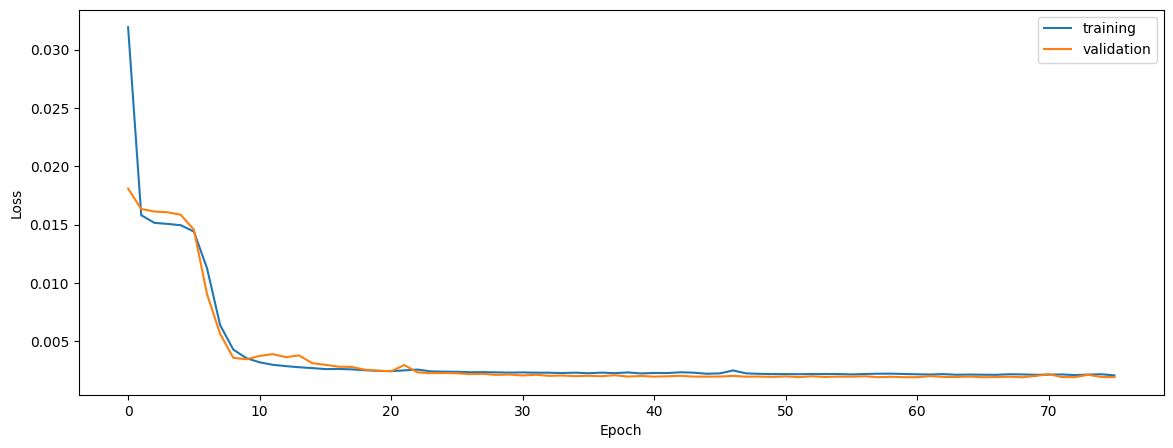

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9285045178842282
0.9398639822969611
0.9606418371879997


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9285045178842282
0.9398639822969611
0.9606418371879997


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9426169531036872
0.95526178030965
0.9756314343785452


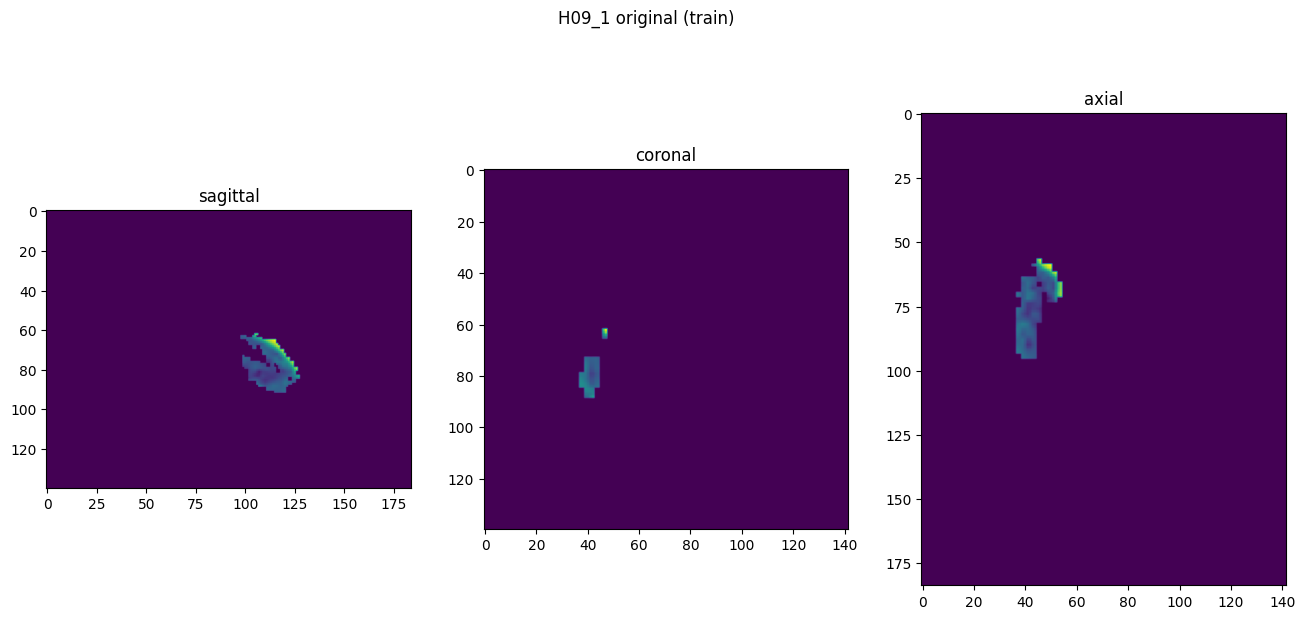

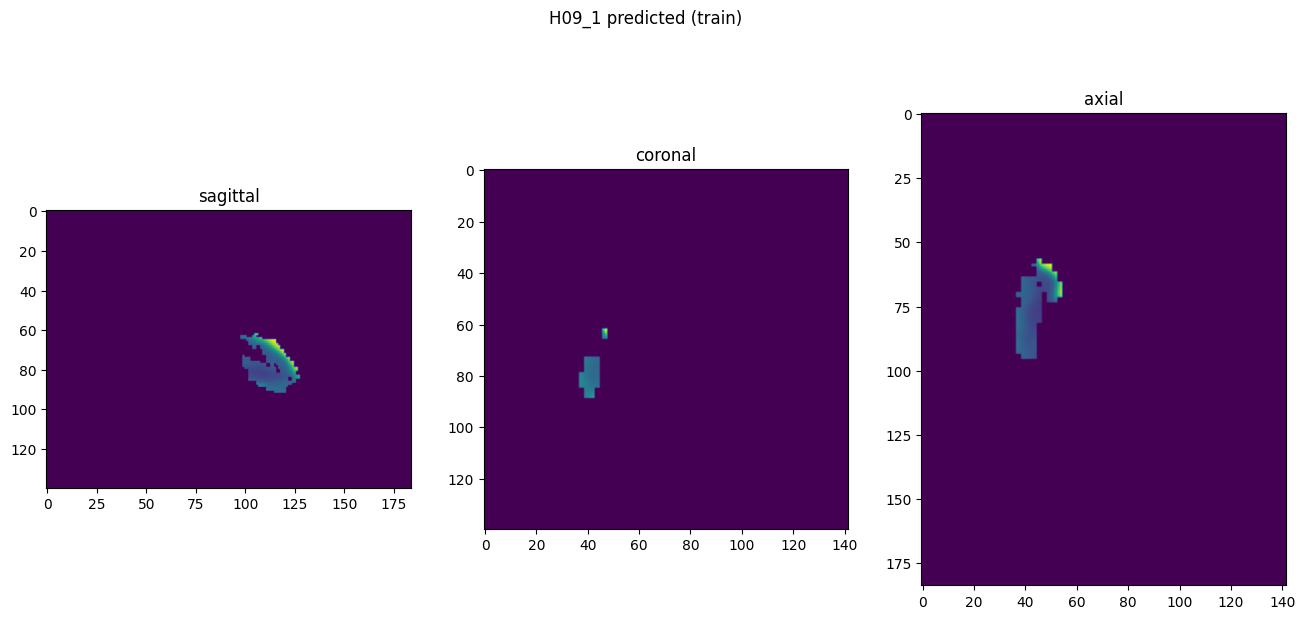

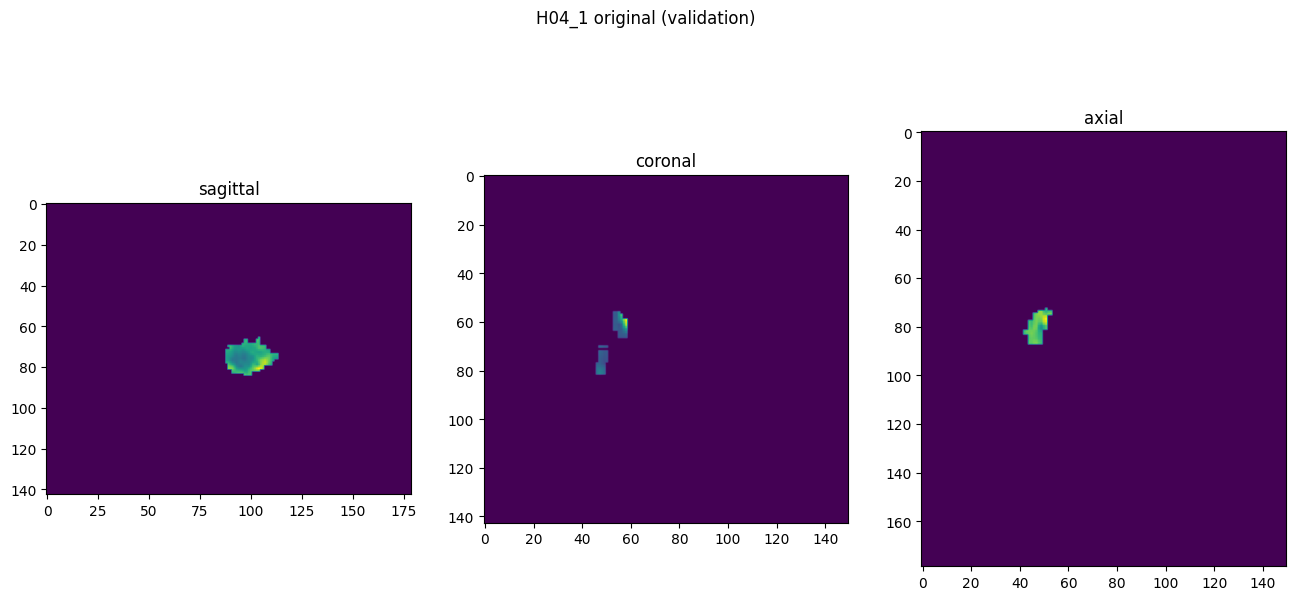

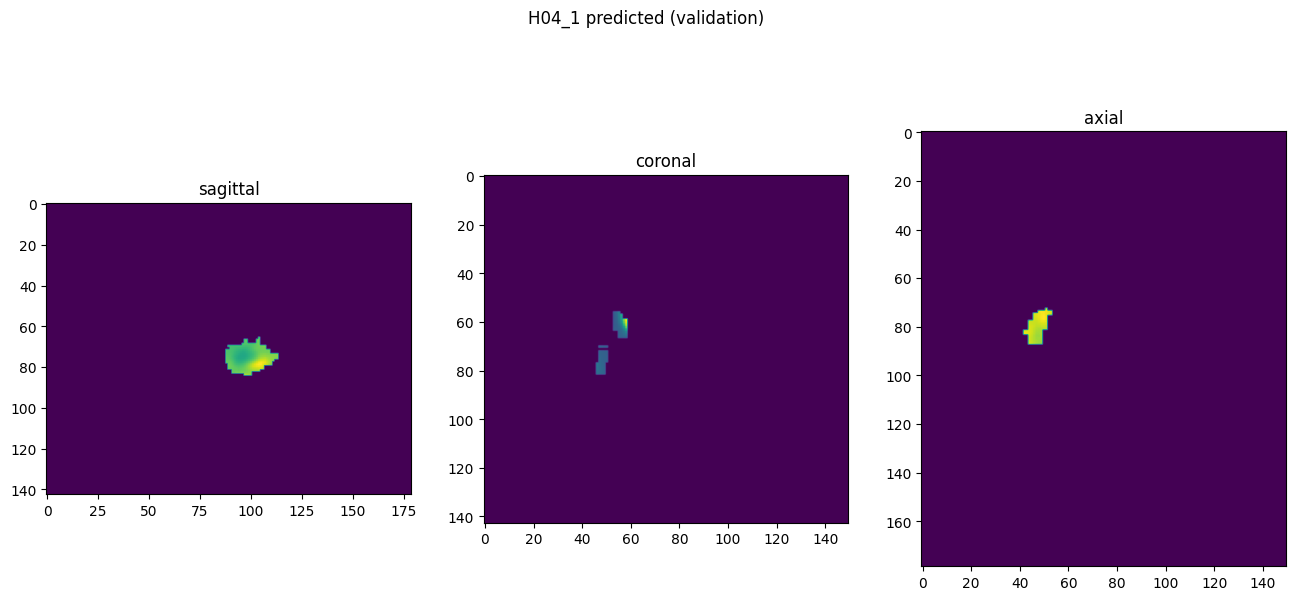

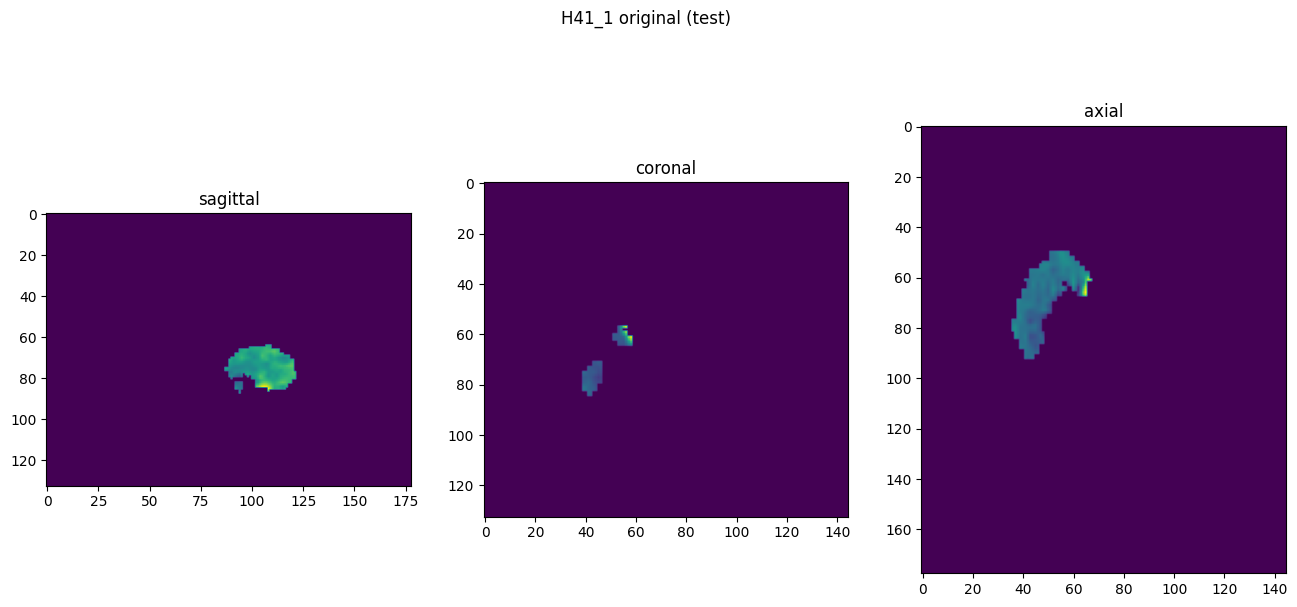

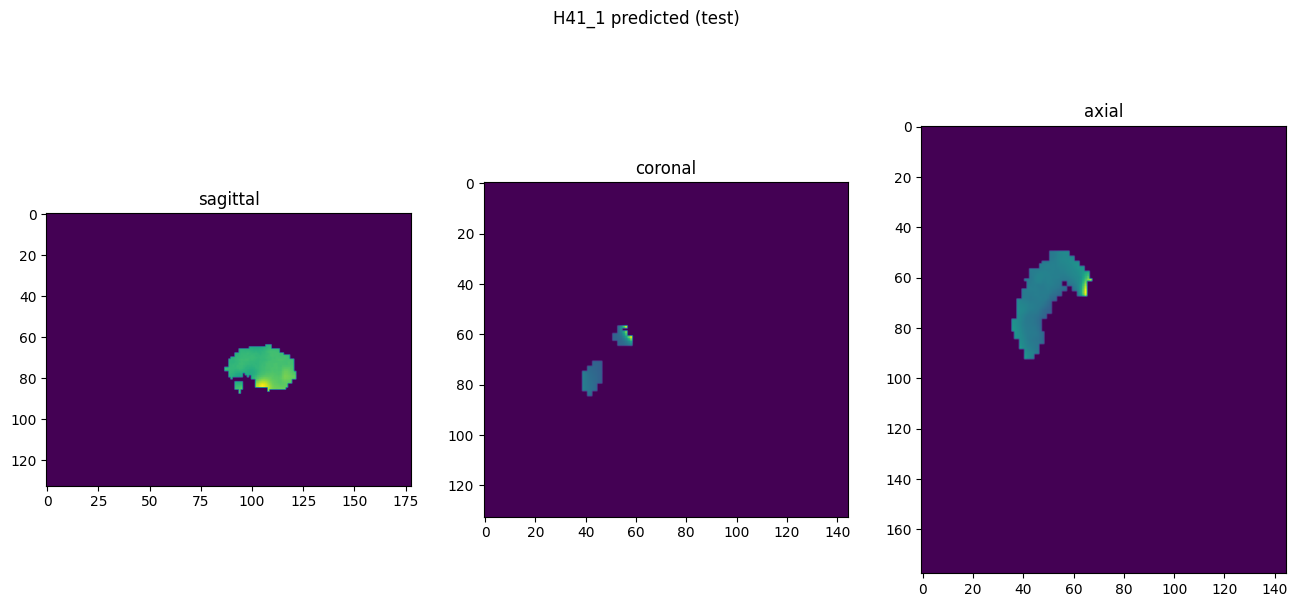

In [10]:
showResults(model, gen, threshold=None, background=False)